In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.decomposition import PCA
from sklearn.svm import SVC
import os
import cv2

In [2]:
# Extract class names from the training directory
training_dir = "training"
classes = os.listdir(training_dir)


In [3]:
# Load all images from the training directory and their labels
X_train = []
Y_train = []
for cls_idx, cls in enumerate(classes):
    class_path = os.path.join(training_dir, cls)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        img = cv2.imread(img_path, 0)  # Read image in grayscale
        img = cv2.resize(img, (200, 200))
        X_train.append(img.flatten())
        Y_train.append(cls_idx)


In [4]:
# Convert to numpy arrays
X_train = np.array(X_train)
Y_train = np.array(Y_train)


In [5]:
# Preprocess data
X_train = X_train / 255.0

In [6]:
# Split the data into training and testing sets
xtrain, xtest, ytrain, ytest = train_test_split(X_train, Y_train, random_state=10, test_size=.20)

In [7]:

# Apply PCA
pca = PCA(n_components=0.98)
pca.fit(xtrain)
pca_train = pca.transform(xtrain)
pca_test = pca.transform(xtest)

In [8]:
# Train SVM model
svm_model = SVC(probability=True)
svm_model.fit(pca_train, ytrain)

SVC(probability=True)

In [9]:
import joblib
# Save PCA transformer and SVM model
joblib.dump(pca, 'pca_transformer.joblib')
joblib.dump(svm_model, 'svm_model.joblib')


['svm_model.joblib']

In [10]:

# Predict on testing data
y_pred = svm_model.predict(pca_test)

In [11]:
# Compute accuracy
accuracy = accuracy_score(ytest, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 87.93%


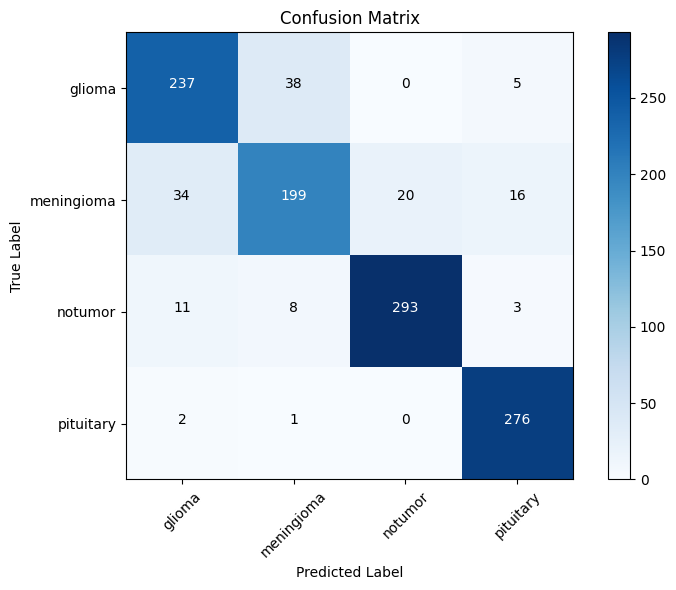

Classification Report:
              precision    recall  f1-score   support

      glioma       0.83      0.85      0.84       280
  meningioma       0.81      0.74      0.77       269
     notumor       0.94      0.93      0.93       315
   pituitary       0.92      0.99      0.95       279

    accuracy                           0.88      1143
   macro avg       0.87      0.88      0.87      1143
weighted avg       0.88      0.88      0.88      1143



In [12]:
# Generate confusion matrix
conf_matrix = confusion_matrix(ytest, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add values to the confusion matrix plot
thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(ytest, y_pred, target_names=classes))



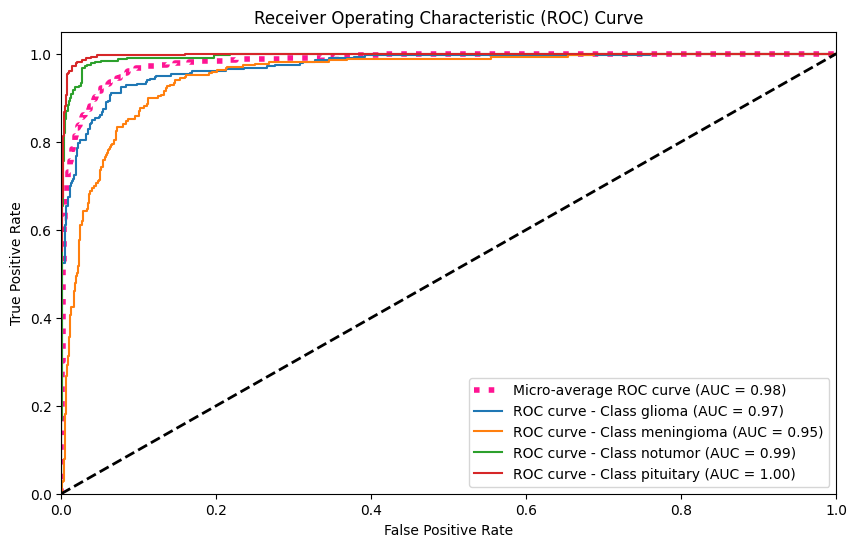

In [15]:
# Plot ROC curve
y_score = svm_model.predict_proba(pca_test)

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(np.array(pd.get_dummies(ytest))[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(np.array(pd.get_dummies(ytest)).ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr["micro"], tpr["micro"], label=f'Micro-average ROC curve (AUC = {roc_auc["micro"]:0.2f})', color='deeppink', linestyle=':', linewidth=4)

for i in range(len(classes)):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve - Class {classes[i]} (AUC = {roc_auc[i]:0.2f})')
    
plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()